In [2]:
import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

###### Loading images
from skimage.transform import resize
stimuli = torch.stack([torch.from_numpy(resize(images[0][i], (224, 224,3))) for i in range(len(images[0]))])

stimuli.size()
import torchvision
grid_img = torchvision.utils.make_grid(stimuli.permute((0,3,1,2)))
grid_img.shape
plt.imshow(grid_img.permute(1, 2, 0))


PROJECT WORDS along previous dimensions

In [5]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/wordsets/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 200) for x in ['train']}
images, classes = next(iter(dataloaders['train']))

np.shape(images)

torch.Size([176, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 4973.5, -0.5)

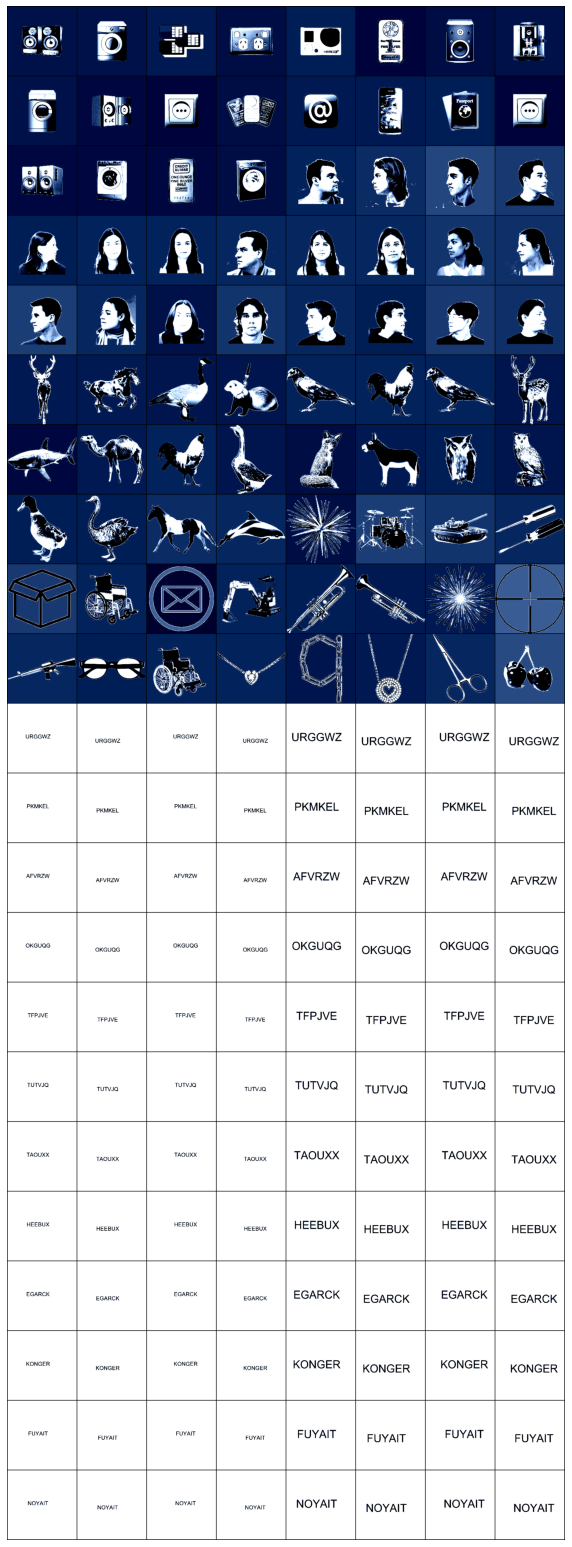

In [6]:
import torchvision

grid = torchvision.utils.make_grid(images)
plt.figure(figsize = (10,100))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')


In [7]:
stimtemp = images[:,:,:,:]

# Loading all the three network and extracting representation from all the hidden units
ili = {}
net = CORnet_Z_tweak()
checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# ili['v1'], ili['v2'], ili['v4'], ili['it'], ili['h'],  ili['out'] = net(stimtemp.float())
ili['v1'], ili['v2'], ili['v4'], ili['it'], ili['h'],  ili['out'] = net(stimtemp.float())

Bli = {}
net = CORNet_Z_biased_words()
checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
Bli['v1'], Bli['v2'], Bli['v4'], Bli['it'], Bli['h'],  Bli['out'] = net(stimtemp.float())


nBli = {}
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)

nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())

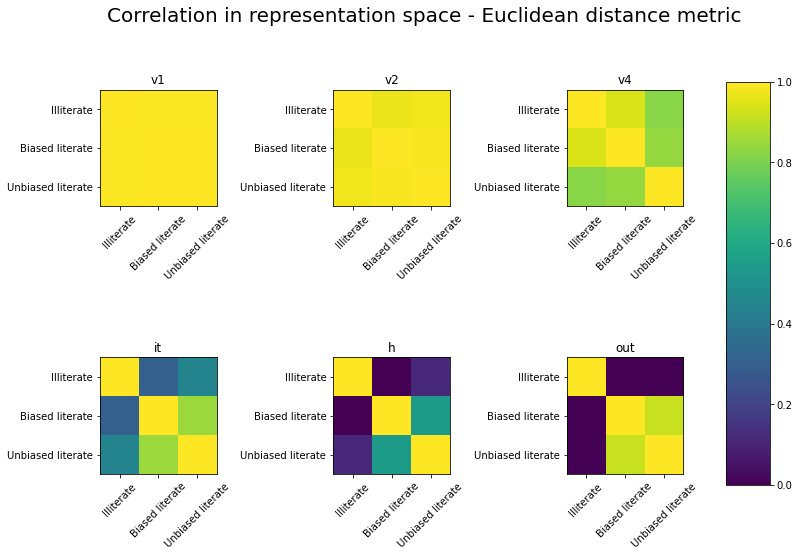

array([[ 1.        , -0.33449848, -0.23242843],
       [-0.33449848,  1.        ,  0.91767909],
       [-0.23242843,  0.91767909,  1.        ]])

In [8]:
# my_dict = {}

# Comparing representation across word and image network
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from scipy.special import comb


fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace=1)
axs = axs.ravel()

roi_ID = ['v1', 'v2', 'v4','it','h','out']; distMetric = 'euclidean'
for idx in range(len(roi_ID)):
    D = np.zeros((comb(np.size(stimtemp,0), 2,exact =True),3)); 
    D[:,0] = squareform(pairwise_distances(ili[roi_ID[idx]].detach().numpy(),metric = distMetric))
    D[:,1] = squareform(pairwise_distances(Bli[roi_ID[idx]].detach().numpy(),metric = distMetric))
    D[:,2] = squareform(pairwise_distances(nBli[roi_ID[idx]].detach().numpy(),metric = distMetric))

    Dcorr = 1-(pairwise_distances(D.T,metric = 'correlation'))
    im = axs[idx].imshow(Dcorr,vmin=0, vmax=1)
    axs[idx].set_yticks([0,1,2]);     axs[idx].set_xticks([0,1,2])
    axs[idx].set_yticklabels(['Illiterate', 'Biased literate','Unbiased literate'])
    axs[idx].set_xticklabels(['Illiterate', 'Biased literate','Unbiased literate'], rotation = 45)
    axs[idx].set_title(roi_ID[idx])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Correlation in representation space - Euclidean distance metric', fontsize=20)
plt.show()

Dcorr

Text(0.5, 0.98, 'Non-biased literate network - PC space')

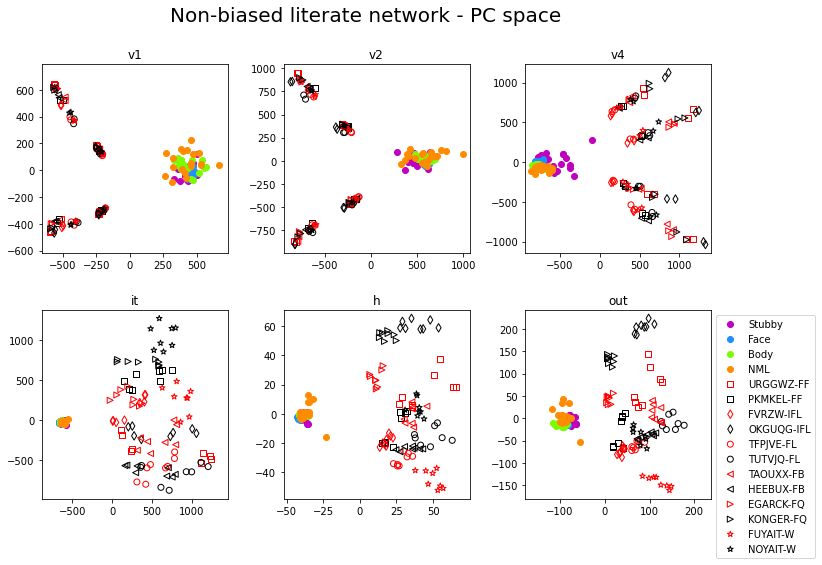

In [57]:
# PCA in python without any normalization or whiten matches PCA of MATLAB
from sklearn.decomposition import PCA
pcax = PCA(n_components=2)

fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

for idx in range(len(roi_ID)):
    
    out = pcax.fit_transform(nBli[roi_ID[idx]].detach().numpy())
    q = range(20);    axs[idx].scatter(out[q, 0], out[q, 1],color = 'm')
    q = range(21,40); axs[idx].scatter(out[q, 0], out[q, 1],color = 'dodgerblue')
    q = range(41,60); axs[idx].scatter(out[q, 0], out[q, 1],color = 'lawngreen')
    q = range(61,80); axs[idx].scatter(out[q, 0], out[q, 1],color = 'darkorange')
    ix = 0
    q = np.array(range(80+ix,88+ix)); axs[idx].scatter(out[q, 0], out[q, 1], marker='s',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='s',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='d',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='d',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='o',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='o',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='<',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='<',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='>',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='>',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='*',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='*',facecolors='none',edgecolor = 'k')

           

    axs[idx].axis('equal');
    axs[idx].set_title(roi_ID[idx])
LEG = ['Stubby', 'Face', 'Body', 'NML', 'URGGWZ-FF', 'PKMKEL-FF', 'FVRZW-IFL', 'OKGUQG-IFL', 'TFPJVE-FL',
       'TUTVJQ-FL', 'TAOUXX-FB', 'HEEBUX-FB', 'EGARCK-FQ', 'KONGER-FQ', 'FUYAIT-W', 'NOYAIT-W']

plt.legend((LEG[:]), bbox_to_anchor=(1, 1))
fig.suptitle('Non-biased literate network - PC space', fontsize=20)

    

Text(0.5, 0.98, 'Non-biased literate network - PC space')

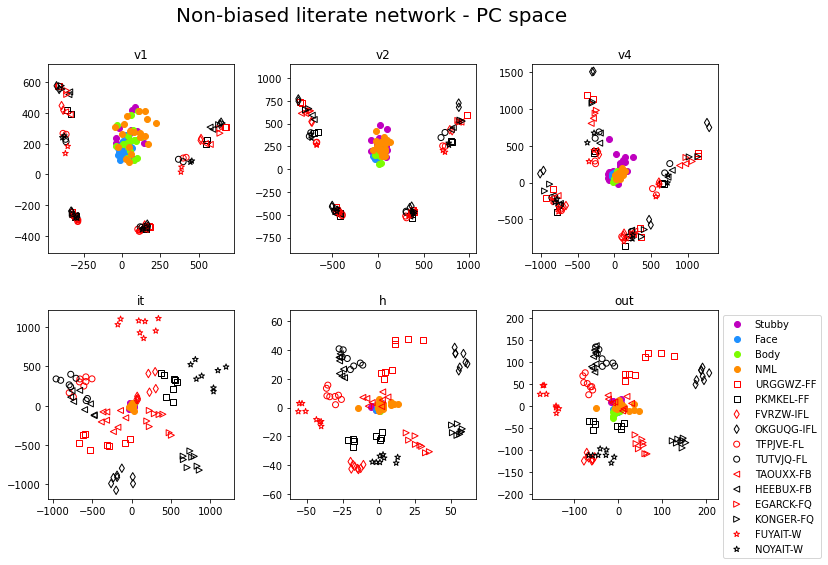

In [65]:
########### Projecting word stimuli on PC space of letters
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

twod = True
if twod:
    fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.3)
    axs = axs.ravel()
    npc = 2
else: 
    fig = plt.figure(figsize=(12,8))
    npc = 3

for idx in range(len(roi_ID)):
    x = nBli[roi_ID[idx]].detach().numpy()
#     x = StandardScaler().fit_transform(x)
    pcax = PCA(n_components=npc, whiten = 0)
    out = pcax.fit_transform(x[:80,:])
    out2 = x[80:,:]@np.transpose(pcax.components_)
        
    if twod:

        q = range(20);    axs[idx].scatter(out[q, 0], out[q, 1],color = 'm')
        q = range(21,40); axs[idx].scatter(out[q, 0], out[q, 1],color = 'dodgerblue')
        q = range(41,60); axs[idx].scatter(out[q, 0], out[q, 1],color = 'lawngreen')
        q = range(61,80); axs[idx].scatter(out[q, 0], out[q, 1],color = 'darkorange')
        ix = -80
        q = np.array(range(80+ix,88+ix)); axs[idx].scatter(out2[q, 0], out2[q, 1], marker='s',facecolors='none',edgecolor = 'r')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='s',facecolors='none',edgecolor = 'k')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='d',facecolors='none',edgecolor = 'r')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='d',facecolors='none',edgecolor = 'k')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='o',facecolors='none',edgecolor = 'r')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='o',facecolors='none',edgecolor = 'k')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='<',facecolors='none',edgecolor = 'r')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='<',facecolors='none',edgecolor = 'k')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='>',facecolors='none',edgecolor = 'r')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='>',facecolors='none',edgecolor = 'k')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='*',facecolors='none',edgecolor = 'r')
        q = q+8; axs[idx].scatter(out2[q, 0], out2[q, 1], marker='*',facecolors='none',edgecolor = 'k')

        axs[idx].axis('equal');
        axs[idx].set_title(roi_ID[idx])
    else:
        axes = fig.add_subplot(2,3,idx+1, projection='3d')
        q = range(20);    axes.scatter3D(out[q, 0], out[q, 1], out[q, 2])
        q = range(21,40); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2])
        q = range(41,60); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2])
        q = range(61,80); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2])
        ix = 29
        q = range(51+ix,59+ix); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2], marker='d')
        q = range(59+ix,67+ix); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2], marker='d')
        q = range(67+ix,75+ix); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2], marker='d')
        q = range(75+ix,83+ix); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2], marker='d')
        q = range(83+ix,91+ix); axes.scatter3D(out[q, 0], out[q, 1], out[q, 2], marker='d')
        axes.set_title(roi_ID[idx])

LEG = ['Stubby', 'Face', 'Body', 'NML', 'URGGWZ-FF', 'PKMKEL-FF', 'FVRZW-IFL', 'OKGUQG-IFL', 'TFPJVE-FL',
       'TUTVJQ-FL', 'TAOUXX-FB', 'HEEBUX-FB', 'EGARCK-FQ', 'KONGER-FQ', 'FUYAIT-W', 'NOYAIT-W']      

plt.legend((LEG), bbox_to_anchor=(1, 1))
fig.suptitle('Non-biased literate network - PC space', fontsize=20)

    

In [66]:
def cmdscale(D):
    """Classical multidimensional scaling (MDS)

    Args:
        D (numpy.array)
            Symmetric distance matrix (n, n)

    Returns:
        Y (numpy.array)
            Configuration matrix (n, p). Each column represents a dimension. Only the
            p dimensions corresponding to positive eigenvalues of B are returned.
            Note that each dimension is only determined up to an overall sign,
            corresponding to a reflection.
        e (numpy.array)
            Eigenvalues of B (n, 1)
    """
    # Number of points
    n = len(D)

    # Centering matrix
    H = np.eye(n) - np.ones((n, n))/n

    # YY^T
    B = -H.dot(D**2).dot(H)/2

    # Diagonalize
    evals, evecs = np.linalg.eigh(B)

    # Sort by eigenvalue in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Compute the coordinates using positive-eigenvalued components only
    w, = np.where(evals > 0)
    L = np.diag(np.sqrt(evals[w]))
    V = evecs[:, w]
    Y = V.dot(L)

    return Y, evals[evals > 0]


D:\software_installation\Anaconda\lib\site-packages\sklearn\manifold\_mds.py:238: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(
D:\software_installation\Anaconda\lib\site-packages\sklearn\manifold\_mds.py:238: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(
D:\software_installation\Anaconda\lib\site-packages\sklearn\manifold\_mds.py:238: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(
D:\software_installation\Anaconda\lib\site-packages\sklearn\manifold\_mds.py:238: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(
D:\software_installation\Anaconda\lib\site-packages\sklearn\manifold\_mds.py:238: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(
D:\software_installa

Text(0.5, 0.98, 'Illiterate network - MDS space')

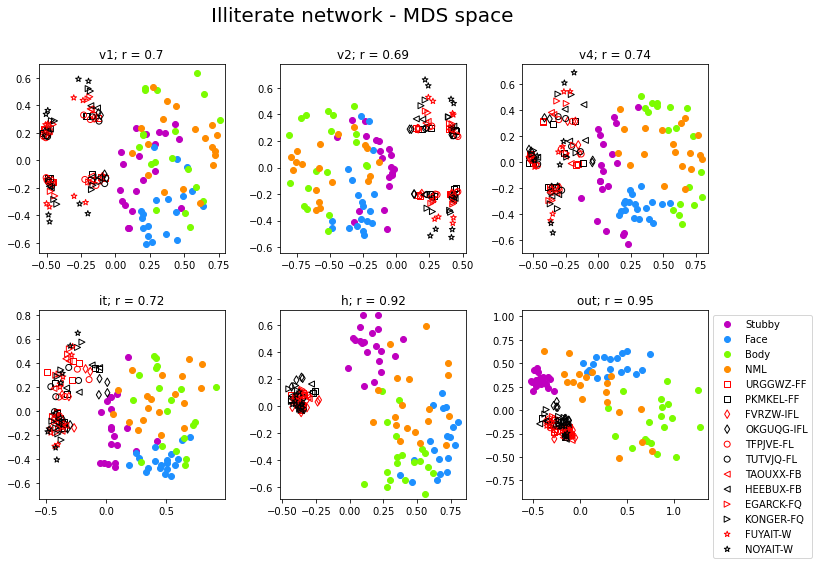

In [123]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist

fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

for idx in range(len(roi_ID)):

    D = pairwise_distances(ili[roi_ID[idx]].detach().numpy(),metric = 'correlation')

    # Implementing classical MDS to estimate the starting point
    Y = cmdscale(D); initialpts = (Y[0][:,:2])    
    
    model = MDS(n_components=2, metric = False, dissimilarity='precomputed')
    out = model.fit_transform(D,init = initialpts)
    Dest = pdist(out,metric = 'euclidean')
    corrval = np.corrcoef(squareform(D), Dest)
    
    q = range(20);    axs[idx].scatter(out[q, 0], out[q, 1],color = 'm')
    q = range(21,40); axs[idx].scatter(out[q, 0], out[q, 1],color = 'dodgerblue')
    q = range(41,60); axs[idx].scatter(out[q, 0], out[q, 1],color = 'lawngreen')
    q = range(61,80); axs[idx].scatter(out[q, 0], out[q, 1],color = 'darkorange')
    ix = 0
    q = np.array(range(80+ix,88+ix)); axs[idx].scatter(out[q, 0], out[q, 1], marker='s',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='s',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='d',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='d',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='o',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='o',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='<',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='<',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='>',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='>',facecolors='none',edgecolor = 'k')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='*',facecolors='none',edgecolor = 'r')
    q = q+8; axs[idx].scatter(out[q, 0], out[q, 1], marker='*',facecolors='none',edgecolor = 'k')

           

    axs[idx].axis('equal');
    axs[idx].set_title(roi_ID[idx] + '; r = ' + str(round(corrval[1,0],2)))
LEG = ['Stubby', 'Face', 'Body', 'NML', 'URGGWZ-FF', 'PKMKEL-FF', 'FVRZW-IFL', 'OKGUQG-IFL', 'TFPJVE-FL',
       'TUTVJQ-FL', 'TAOUXX-FB', 'HEEBUX-FB', 'EGARCK-FQ', 'KONGER-FQ', 'FUYAIT-W', 'NOYAIT-W']

plt.legend((LEG[:]), bbox_to_anchor=(1, 1))
fig.suptitle('Illiterate network - MDS space', fontsize=20)

    
    

In [117]:
[roi_ID[idx] + '; r = ' + str(round(corrval[1,0],2))]

['v1; r = 0.7']

In [ ]:
# Measuring visual dissimilarity across ROIs
item = np.reshape(range(40),[5, 8])

Dmean = np.zeros((len(roi_ID),5))
for idx in range(len(roi_ID)):
    for stim in range(5):
        D = pairwise_distances(ili[roi_ID[idx]][item[stim,:],:].detach().numpy(),metric = 'correlation')
        Dmean[idx,stim] = np.mean(D)
    
df = pd.DataFrame(Dmean)
df.plot(kind='bar')
plt.legend(['dimanche', 'lundi', 'samedi', 'semaine', 'wxyz'])
plt.xticks(ticks=range(len(roi_ID)), labels = roi_ID, rotation = 0,fontsize = 15)
plt.title('Biased literate network', fontsize=15)
plt.ylabel('Mean dissimilarity',fontsize = 15)

In [ ]:
np.shape(ili[roi_ID[idx]][item[stim,:],:])

###### import numpy as np
from scipy.io import loadmat
annots = loadmat('pcadata.mat')
np.shape(annots['meas']) 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pcax = PCA(n_components=4, whiten = 0)
x = annots['meas']
x = StandardScaler().fit_transform(x)

out = pcax.fit_transform(x)

annots['meas']- np.mean(annots['meas'],0)
